In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Hourly
from datetime import datetime
from pandas.api.types import CategoricalDtype

#set notebook options
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 10})
sns.set_style("white")
plt_color = 'cadetblue'

In [4]:
df = pd.read_csv('./Data/Motor_Vehicle_Collisions_Crashes.csv')

In [5]:
df['HOUR'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.hour
df['MINUTE'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.minute
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['WEEKDAY'] = df['CRASH DATE'].dt.day_name()
dayorder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['WEEKDAY'] = df['WEEKDAY'].astype(CategoricalDtype(categories=dayorder, ordered=True))
df['HOUR OF WEEK'] = df['CRASH DATE'].dt.dayofweek * 24 + (df.HOUR + 1).astype(int)

# drop data incomplete years
df = df[(df.YEAR > 2020) & (df.YEAR < 2024)]
df = df[(df.LONGITUDE != 0.000000) | (df.LATITUDE != 0.000000)]

#sort data on CRASH DATE
df = df.sort_values(by=['CRASH DATE']).reset_index(drop=True)

# keep data from 2017-2022
#df = df[(df['YEAR'] >= 2017) & (df['YEAR'] <= 2022)]

In [42]:
# calcuæate number of collisions with no injuries or fatalities
# in one line
df['NO INJURIES OR FATALITIES'] = df.apply(lambda x: 1 if (x['NUMBER OF PERSONS INJURED'] == 0) & (x['NUMBER OF PERSONS KILLED'] == 0) else 0, axis=1)
df.sum()

CRASH TIME                       4:356:4519:423:3022:406:503:006:211:402:4010:4...
LATITUDE                                                            8808503.703636
LONGITUDE                                                         -15987794.582183
NUMBER OF PERSONS INJURED                                                 114982.0
NUMBER OF PERSONS KILLED                                                     629.0
NUMBER OF PEDESTRIANS INJURED                                                18613
NUMBER OF PEDESTRIANS KILLED                                                   281
NUMBER OF CYCLIST INJURED                                                    10801
NUMBER OF CYCLIST KILLED                                                        48
NUMBER OF MOTORIST INJURED                                                   80644
NUMBER OF MOTORIST KILLED                                                      266
COLLISION_ID                                                         1061070488073
HOUR

In [41]:
# count number of collisions with no injuries or fatalities
df['NO INJURIES'] = np.where(df['NUMBER OF PERSONS INJURED'] == 0, 1, 0)
df['NO FATALITIES'] = np.where(df['NUMBER OF PERSONS KILLED'] == 0, 1, 0)
df['NO INJURIES OR FATALITIES'] = np.where((df['NUMBER OF PERSONS INJURED'] == 0) & (df['NUMBER OF PERSONS KILLED'] == 0), 1, 0)

df.sum()

CRASH TIME                       4:356:4519:423:3022:406:503:006:211:402:4010:4...
LATITUDE                                                            8808503.703636
LONGITUDE                                                         -15987794.582183
NUMBER OF PERSONS INJURED                                                 114982.0
NUMBER OF PERSONS KILLED                                                     629.0
NUMBER OF PEDESTRIANS INJURED                                                18613
NUMBER OF PEDESTRIANS KILLED                                                   281
NUMBER OF CYCLIST INJURED                                                    10801
NUMBER OF CYCLIST KILLED                                                        48
NUMBER OF MOTORIST INJURED                                                   80644
NUMBER OF MOTORIST KILLED                                                      266
COLLISION_ID                                                         1061070488073
HOUR

In [6]:
df_orig = df.copy()

In [13]:
df = df_orig
df_orig.shape

(235763, 36)

In [8]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,HOUR,MINUTE,YEAR,MONTH,DAY,WEEKDAY,HOUR OF WEEK
0,2021-01-01,4:35,NaN,NaN,40.662556,-73.919630,"(40.662556, -73.91963)",TAPSCOTT STREET,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4381436,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,4,35,2021,1,1,Friday,101
1,2021-01-01,6:45,NaN,NaN,NaN,NaN,NaN,BROOKVILLE BOULEVARD,ROCKAWAY BOULEVARD,NaN,0.0,0.0,0,0,0,0,0,0,Pavement Slippery,Pavement Slippery,Pavement Slippery,NaN,NaN,4380783,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,6,45,2021,1,1,Friday,103
2,2021-01-01,19:42,NaN,NaN,40.861862,-73.912820,"(40.861862, -73.91282)",WEST FORDHAM ROAD,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4380919,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,19,42,2021,1,1,Friday,116
3,2021-01-01,3:30,BRONX,10466.0,40.902706,-73.841545,"(40.902706, -73.841545)",NaN,NaN,1047 EAST 241 STREET,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4381141,Sedan,NaN,NaN,NaN,NaN,3,30,2021,1,1,Friday,100
4,2021-01-01,22:40,QUEENS,11372.0,40.750824,-73.874090,"(40.750824, -73.87409)",93 STREET,37 AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4381350,NaN,NaN,NaN,NaN,NaN,22,40,2021,1,1,Friday,119


In [12]:
# only keep collisions if a person is injured or killed
df = df[(df['NUMBER OF PERSONS INJURED'] > 0) | (df['NUMBER OF PERSONS KILLED'] > 0)]
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,HOUR,MINUTE,YEAR,MONTH,DAY,WEEKDAY,HOUR OF WEEK
4,2021-01-01,22:40,QUEENS,11372.0,40.750824,-73.874090,"(40.750824, -73.87409)",93 STREET,37 AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4381350,NaN,NaN,NaN,NaN,NaN,22,40,2021,1,1,Friday,119
5,2021-01-01,6:50,NaN,NaN,40.856743,-73.917625,"(40.856743, -73.917625)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,3.0,0.0,0,0,0,0,3,0,Unsafe Speed,Tinted Windows,Unspecified,Unspecified,Unspecified,4380839,Station Wagon/Sport Utility Vehicle,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,6,50,2021,1,1,Friday,103
9,2021-01-01,2:40,NaN,NaN,40.744530,-73.988880,"(40.74453, -73.98888)",WEST 27 STREET,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Steering Failure,Unspecified,NaN,NaN,NaN,4381115,Sedan,Pick-up Truck,NaN,NaN,NaN,2,40,2021,1,1,Friday,99
13,2021-01-01,20:25,BRONX,10472.0,40.826920,-73.871990,"(40.82692, -73.87199)",WATSON AVENUE,SOUND VIEW AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4381469,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,20,25,2021,1,1,Friday,117
21,2021-01-01,17:25,QUEENS,11373.0,40.745697,-73.886420,"(40.745697, -73.88642)",41 AVENUE,79 STREET,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4381160,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,17,25,2021,1,1,Friday,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235753,2023-04-10,19:20,BROOKLYN,11236.0,40.635190,-73.912950,"(40.63519, -73.91295)",NaN,NaN,772 EAST 80 STREET,1.0,0.0,0,0,0,0,1,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4619691,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,19,20,2023,4,10,Monday,20
235754,2023-04-10,21:30,NaN,NaN,40.666530,-73.806274,"(40.66653, -73.806274)",BELT PARKWAY,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Following Too Closely,Unspecified,Unspecified,Unspecified,NaN,4619956,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,21,30,2023,4,10,Monday,22
235755,2023-04-10,13:23,NaN,NaN,40.632793,-74.134050,"(40.632793, -74.13405)",POST AVENUE,HEBERTON AVENUE,NaN,6.0,0.0,0,0,0,0,6,0,Traffic Control Disregarded,Traffic Control Disregarded,NaN,NaN,NaN,4619749,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,13,23,2023,4,10,Monday,14
235760,2023-04-10,14:35,BROOKLYN,11219.0,40.634075,-73.995080,"(40.634075, -73.99508)",NEW UTRECHT AVENUE,52 STREET,NaN,2.0,0.0,0,0,0,0,2,0,Unspecified,Unspecified,NaN,NaN,NaN,4619735,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,14,35,2023,4,10,Monday,15


In [ ]:
# categorize collisions two fold: by type and severity

In [16]:
# categorize data depending on whether a motorist, cyclist, or pedestrian was involved
df['MOTORIST'] = np.where((df['NUMBER OF MOTORIST INJURED'] > 0) | (df['NUMBER OF MOTORIST KILLED'] > 0), 1, 0)
df['CYCLIST'] = np.where((df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0), 1, 0)
df['PEDESTRIAN'] = np.where((df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (df['NUMBER OF PEDESTRIANS KILLED'] > 0), 1, 0)

df.head()


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,HOUR,MINUTE,YEAR,MONTH,DAY,WEEKDAY,HOUR OF WEEK,MOTORIST,CYCLIST,PEDESTRIAN
0,2021-01-01,4:35,NaN,NaN,40.662556,-73.919630,"(40.662556, -73.91963)",TAPSCOTT STREET,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4381436,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,4,35,2021,1,1,Friday,101,0,0,0
1,2021-01-01,6:45,NaN,NaN,NaN,NaN,NaN,BROOKVILLE BOULEVARD,ROCKAWAY BOULEVARD,NaN,0.0,0.0,0,0,0,0,0,0,Pavement Slippery,Pavement Slippery,Pavement Slippery,NaN,NaN,4380783,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,6,45,2021,1,1,Friday,103,0,0,0
2,2021-01-01,19:42,NaN,NaN,40.861862,-73.912820,"(40.861862, -73.91282)",WEST FORDHAM ROAD,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4380919,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,19,42,2021,1,1,Friday,116,0,0,0
3,2021-01-01,3:30,BRONX,10466.0,40.902706,-73.841545,"(40.902706, -73.841545)",NaN,NaN,1047 EAST 241 STREET,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4381141,Sedan,NaN,NaN,NaN,NaN,3,30,2021,1,1,Friday,100,0,0,0
4,2021-01-01,22:40,QUEENS,11372.0,40.750824,-73.874090,"(40.750824, -73.87409)",93 STREET,37 AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4381350,NaN,NaN,NaN,NaN,NaN,22,40,2021,1,1,Friday,119,0,0,1


In [ ]:
# What factors contribute the most to the different types of collisions?
# What are the most common types of collisions?

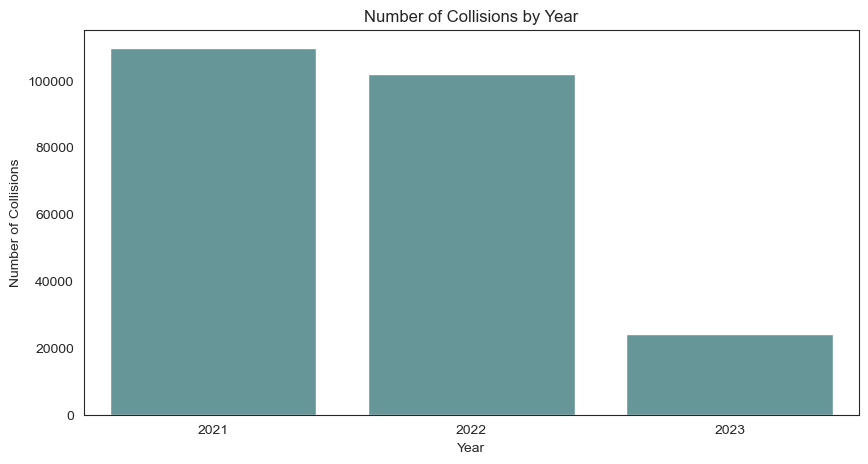

In [17]:
# plot the number of collisions by year
plt.figure(figsize=(10,5))
sns.countplot(x='YEAR', data=df, color=plt_color)
plt.title('Number of Collisions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.show()


In [ ]:
# plot the most frequent contributing factors for each type of collision
# sort the data by the most frequent contributing factors
df_motorist = df[df['MOTORIST'] == 1]
df_motorist = df_motorist['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().reset_index()
df_motorist.columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'COUNT']
df_motorist = df_motorist.sort_values(by=['COUNT'], ascending=False).reset_index(drop=True)

df_cyclist = df[df['CYCLIST'] == 1]
df_cyclist = df_cyclist['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().reset_index()
df_cyclist.columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'COUNT']
df_cyclist = df_cyclist.sort_values(by=['COUNT'], ascending=False).reset_index(drop=True)

df_pedestrian = df[df['PEDESTRIAN'] == 1]
df_pedestrian = df_pedestrian['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().reset_index()
df_pedestrian.columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'COUNT']
df_pedestrian = df_pedestrian.sort_values(by=['COUNT'], ascending=False).reset_index(drop=True)


# remove "Unspecified" from the data
df_motorist = df_motorist[df_motorist['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_cyclist = df_cyclist[df_cyclist['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_pedestrian = df_pedestrian[df_pedestrian['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']

# plot the most frequent contributing factors for each type of collision
plt.figure(figsize=(10,5))
sns.barplot(x='CONTRIBUTING FACTOR VEHICLE 1', y='COUNT', data=df_motorist.head(10), color=plt_color)
plt.title('Most Frequent Contributing Factors for Motorists')
plt.xlabel('Contributing Factor')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='CONTRIBUTING FACTOR VEHICLE 1', y='COUNT', data=df_cyclist.head(10), color=plt_color)
plt.title('Most Frequent Contributing Factors for Cyclists')
plt.xlabel('Contributing Factor')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='CONTRIBUTING FACTOR VEHICLE 1', y='COUNT', data=df_pedestrian.head(10), color=plt_color)
plt.title('Most Frequent Contributing Factors for Pedestrians')
plt.xlabel('Contributing Factor')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# plot the most frequent contributing factors for each type of collision grouped by severity


In [46]:
# categorize data depending on whether a motorist, cyclist, or pedestrian was involved but grouped by severity
df['MOTORIST INJURED'] = np.where(df['NUMBER OF MOTORIST INJURED'] > 0, 1, 0)
df['MOTORIST KILLED'] = np.where(df['NUMBER OF MOTORIST KILLED'] > 0, 1, 0)
df['CYCLIST INJURED'] = np.where(df['NUMBER OF CYCLIST INJURED'] > 0, 1, 0)
df['CYCLIST KILLED'] = np.where(df['NUMBER OF CYCLIST KILLED'] > 0, 1, 0)
df['PEDESTRIAN INJURED'] = np.where(df['NUMBER OF PEDESTRIANS INJURED'] > 0, 1, 0)
df['PEDESTRIAN KILLED'] = np.where(df['NUMBER OF PEDESTRIANS KILLED'] > 0, 1, 0)

# plot the most frequent contributing factors for each type of collision in a bar plot stacked by severity
df_motorist = df[df['MOTORIST'] == 1]
df_motorist = df_motorist[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST INJURED', 'MOTORIST KILLED']]
df_motorist = df_motorist.groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_motorist = df_motorist.sort_values(by=['MOTORIST INJURED', 'MOTORIST KILLED'], ascending=False).reset_index(drop=True)

df_cyclist = df[df['CYCLIST'] == 1]
df_cyclist = df_cyclist[['CONTRIBUTING FACTOR VEHICLE 1', 'CYCLIST INJURED', 'CYCLIST KILLED']]
df_cyclist = df_cyclist.groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_cyclist = df_cyclist.sort_values(by=['CYCLIST INJURED', 'CYCLIST KILLED'], ascending=False).reset_index(drop=True)

df_pedestrian = df[df['PEDESTRIAN'] == 1]
df_pedestrian = df_pedestrian[['CONTRIBUTING FACTOR VEHICLE 1', 'PEDESTRIAN INJURED', 'PEDESTRIAN KILLED']]
df_pedestrian = df_pedestrian.groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_pedestrian = df_pedestrian.sort_values(by=['PEDESTRIAN INJURED', 'PEDESTRIAN KILLED'], ascending=False).reset_index(drop=True)

# remove "Unspecified" from the data
df_motorist = df_motorist[df_motorist['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_cyclist = df_cyclist[df_cyclist['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_pedestrian = df_pedestrian[df_pedestrian['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']

# make bokeh stacked bar plot with three tabs for each category
# create a ColumnDataSource object for each category
source_motorist = ColumnDataSource(df_motorist)
source_cyclist = ColumnDataSource(df_cyclist)
source_pedestrian = ColumnDataSource(df_pedestrian)

# create a figure object for each category
p_motorist = figure(x_range=df_motorist['CONTRIBUTING FACTOR VEHICLE 1'].head(7), height=500, width=1000, title='Most Frequent Contributing Factors for Motorists', toolbar_location=None, tools='')
p_cyclist = figure(x_range=df_cyclist['CONTRIBUTING FACTOR VEHICLE 1'].head(7), height=500, width=1000, title='Most Frequent Contributing Factors for Cyclists', toolbar_location=None, tools='')
p_pedestrian = figure(x_range=df_pedestrian['CONTRIBUTING FACTOR VEHICLE 1'].head(7), height=500, width=1000, title='Most Frequent Contributing Factors for Pedestrians', toolbar_location=None, tools='')
p_motorist.xaxis.major_label_orientation = math.pi/2
p_cyclist.xaxis.major_label_orientation = math.pi/2
p_pedestrian.xaxis.major_label_orientation = math.pi/2

# create a stacked bar plot for each category
p_motorist.vbar_stack(['MOTORIST INJURED', 'MOTORIST KILLED'], x='CONTRIBUTING FACTOR VEHICLE 1', width=0.9, color=['#1f77b4', '#ff7f0e'], source=source_motorist, legend_label=['Injured', 'Killed'])
p_cyclist.vbar_stack(['CYCLIST INJURED', 'CYCLIST KILLED'], x='CONTRIBUTING FACTOR VEHICLE 1', width=0.9, color=['#1f77b4', '#ff7f0e'], source=source_cyclist, legend_label=['Injured', 'Killed'])
p_pedestrian.vbar_stack(['PEDESTRIAN INJURED', 'PEDESTRIAN KILLED'], x='CONTRIBUTING FACTOR VEHICLE 1', width=0.9, color=['#1f77b4', '#ff7f0e'], source=source_pedestrian, legend_label=['Injured', 'Killed'])

# add hover tool to each figure
hover_motorist = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Injured', '@{MOTORIST INJURED}'), ('Killed', '@{MOTORIST KILLED}')])
hover_cyclist = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Injured', '@{CYCLIST INJURED}'), ('Killed', '@{CYCLIST KILLED}')])
hover_pedestrian = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Injured', '@{PEDESTRIAN INJURED}'), ('Killed', '@{PEDESTRIAN KILLED}')])

p_motorist.add_tools(hover_motorist)
p_cyclist.add_tools(hover_cyclist)
p_pedestrian.add_tools(hover_pedestrian)

# add legend to each figure
p_motorist.legend.location = 'top_right'
p_motorist.legend.orientation = 'horizontal'
p_cyclist.legend.location = 'top_right'
p_cyclist.legend.orientation = 'horizontal'
p_pedestrian.legend.location = 'top_right'
p_pedestrian.legend.orientation = 'horizontal'

# create tabs for each category
tab_motorist = TabPanel(child=p_motorist, title='Motorist')
tab_cyclist = TabPanel(child=p_cyclist, title='Cyclist')
tab_pedestrian = TabPanel(child=p_pedestrian, title='Pedestrian')

# create a Tabs object with the three tabs
tabs = Tabs(tabs=[tab_motorist, tab_cyclist, tab_pedestrian])

# show the plot
show(tabs)

In [49]:
df[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST INJURED', 'CYCLIST INJURED', 'PEDESTRIAN INJURED']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()

,CONTRIBUTING FACTOR VEHICLE 1,MOTORIST INJURED,CYCLIST INJURED,PEDESTRIAN INJURED
0,Accelerator Defective,70,4,4
1,Aggressive Driving/Road Rage,433,44,195
2,Alcohol Involvement,1200,71,78
3,Animals Action,30,2,2
4,Backing Unsafely,598,59,697
5,Brakes Defective,388,26,20
6,Cell Phone (hand-Held),36,2,5
7,Cell Phone (hands-free),5,0,0
8,Driver Inattention/Distraction,13325,3205,4527
9,Driver Inexperience,1142,138,191


In [52]:
# create the same plot but where the tabs correspond to Injured and Killed and the stacked bars correspond to Motorist, Cyclist, and Pedestrian

# create approriate df for injured and killed
df_injured = df[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST INJURED', 'CYCLIST INJURED', 'PEDESTRIAN INJURED']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_killed = df[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST KILLED', 'CYCLIST KILLED', 'PEDESTRIAN KILLED']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()

# sort the df by the sum of the three categories
df_injured['sum'] = df_injured['MOTORIST INJURED'] + df_injured['CYCLIST INJURED'] + df_injured['PEDESTRIAN INJURED']
df_killed['sum'] = df_killed['MOTORIST KILLED'] + df_killed['CYCLIST KILLED'] + df_killed['PEDESTRIAN KILLED']
df_injured = df_injured.sort_values(by=['sum'], ascending=False)
df_killed = df_killed.sort_values(by=['sum'], ascending=False)


# create a ColumnDataSource object for each category
source_injured = ColumnDataSource(df_injured)
source_killed = ColumnDataSource(df_killed)

# create a figure object for each category
p_injured = figure(x_range=df_injured['CONTRIBUTING FACTOR VEHICLE 1'], height=500, width=1000, title='Most Frequent Contributing Factors for Injured', toolbar_location=None, tools='')
p_killed = figure(x_range=df_killed['CONTRIBUTING FACTOR VEHICLE 1'], height=500, width=1000, title='Most Frequent Contributing Factors for Killed', toolbar_location=None, tools='')
p_injured.xaxis.major_label_orientation = math.pi/2
p_killed.xaxis.major_label_orientation = math.pi/2

# create a stacked bar plot for each category
p_injured.vbar_stack(['MOTORIST INJURED', 'CYCLIST INJURED', 'PEDESTRIAN INJURED'], x='CONTRIBUTING FACTOR VEHICLE 1', width=0.9, color=['#1f77b4', '#ff7f0e', '#2ca02c'], source=source_injured, legend_label=['Motorist', 'Cyclist', 'Pedestrian'])
p_killed.vbar_stack(['MOTORIST KILLED', 'CYCLIST KILLED', 'PEDESTRIAN KILLED'], x='CONTRIBUTING FACTOR VEHICLE 1', width=0.9, color=['#1f77b4', '#ff7f0e', '#2ca02c'], source=source_killed, legend_label=['Motorist', 'Cyclist', 'Pedestrian'])

# add hover tool to each figure
hover_injured = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Motorist', '@{MOTORIST INJURED}'), ('Cyclist', '@{CYCLIST INJURED}'), ('Pedestrian', '@{PEDESTRIAN INJURED}')])
hover_killed = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Motorist', '@{MOTORIST KILLED}'), ('Cyclist', '@{CYCLIST KILLED}'), ('Pedestrian', '@{PEDESTRIAN KILLED}')])

p_injured.add_tools(hover_injured)
p_killed.add_tools(hover_killed)

# add legend to each figure
p_injured.legend.location = 'top_right'
p_injured.legend.orientation = 'horizontal'
p_killed.legend.location = 'top_right'
p_killed.legend.orientation = 'horizontal'

# create tabs for each category
tab_injured = TabPanel(child=p_injured, title='Injured')
tab_killed = TabPanel(child=p_killed, title='Killed')

# create a Tabs object with the two tabs
tabs = Tabs(tabs=[tab_injured, tab_killed])

# show the plot
show(tabs)


In [33]:
# import bokeh for interactive plots
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.layouts import gridplot

# import math
import math

# import bokeh panel and tabs

from bokeh.models import TabPanel, Tabs


output_notebook()


Loading BokehJS ...

In [43]:
# make the same plot but as a bokeh plot with three tabs
# create a ColumnDataSource object
source_motorist = ColumnDataSource(df_motorist.head(10))
source_cyclist = ColumnDataSource(df_cyclist.head(10))
source_pedestrian = ColumnDataSource(df_pedestrian.head(10))

# create a figure object
p = figure(x_range=df_motorist['CONTRIBUTING FACTOR VEHICLE 1'].head(6), height=500, width=800, title='Most Frequent Contributing Factors for Motorists')
p.xaxis.major_label_orientation = math.pi/2
p.xaxis.axis_label = 'Contributing Factor'
p.yaxis.axis_label = 'Number of Collisions'

# create a bar plot
p.vbar(x='CONTRIBUTING FACTOR VEHICLE 1', top='COUNT', width=0.5, source=source_motorist, color=plt_color)

# create a hover tool
hover = HoverTool()
hover.tooltips=[
    ('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'),
    ('Number of Collisions', '@COUNT')
]
p.add_tools(hover)

# create a figure object
p2 = figure(x_range=df_cyclist['CONTRIBUTING FACTOR VEHICLE 1'].head(6), height=500, width=800, title='Most Frequent Contributing Factors for Cyclists')
p2.xaxis.major_label_orientation = math.pi/2
p2.xaxis.axis_label = 'Contributing Factor'
p2.yaxis.axis_label = 'Number of Collisions'

# create a bar plot
p2.vbar(x='CONTRIBUTING FACTOR VEHICLE 1', top='COUNT', width=0.5, source=source_cyclist, color=plt_color)

# create a hover tool
hover2 = HoverTool()
hover2.tooltips=[
    ('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'),
    ('Number of Collisions', '@COUNT')
]

p2.add_tools(hover2)

# create a figure object
p3 = figure(x_range=df_pedestrian['CONTRIBUTING FACTOR VEHICLE 1'].head(6), height=500, width=800, title='Most Frequent Contributing Factors for Pedestrians')
p3.xaxis.major_label_orientation = math.pi/2
p3.xaxis.axis_label = 'Contributing Factor'
p3.yaxis.axis_label = 'Number of Collisions'

# create a bar plot
p3.vbar(x='CONTRIBUTING FACTOR VEHICLE 1', top='COUNT', width=0.5, source=source_pedestrian, color=plt_color)

# create a hover tool
hover3 = HoverTool()
hover3.tooltips=[
    ('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'),
    ('Number of Collisions', '@COUNT')
]

p3.add_tools(hover3)

# create a tab layout
tab1 = TabPanel(child=p, title='Motorists')
tab2 = TabPanel(child=p2, title='Cyclists')
tab3 = TabPanel(child=p3, title='Pedestrians')
tabs = Tabs(tabs=[tab1, tab2, tab3])

# show the plot
show(tabs)
